In [33]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import re

# Attention Class

In [10]:
import tensorflow as tf
import os
from tensorflow.python.keras.layers import Layer
from tensorflow.python.keras import backend as K


class AttentionLayer(Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs, verbose=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs
        if verbose:
            print('encoder_out_seq>', encoder_out_seq.shape)
            print('decoder_out_seq>', decoder_out_seq.shape)

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state
            inputs: (batchsize * 1 * de_in_dim)
            states: (batchsize * 1 * de_latent_dim)
            """

            assert_msg = "States must be an iterable. Got {} of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            """ Some parameters required for shaping tensors"""
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch size * en_seq_len * latent_dim
            W_a_dot_s = K.dot(encoder_out_seq, self.W_a)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim
            if verbose:
                print('Ua.h>', U_a_dot_h.shape)

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            Ws_plus_Uh = K.tanh(W_a_dot_s + U_a_dot_h)
            if verbose:
                print('Ws+Uh>', Ws_plus_Uh.shape)

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.squeeze(K.dot(Ws_plus_Uh, self.V_a), axis=-1)
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            if verbose:
                print('ei>', e_i.shape)

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """

            assert_msg = "States must be an iterable. Got {} of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            # <= batch_size, hidden_size
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', c_i.shape)
            return c_i, [c_i]

        fake_state_c = K.sum(encoder_out_seq, axis=1)
        fake_state_e = K.sum(encoder_out_seq, axis=2)  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

# PARSING THROUGH THE DATASET

In [11]:
import re

movie_lines = open('../input/cornell-movie-dataset/cornell/movie_lines.txt', encoding='utf-8',
             errors='ignore').read().split('\n')

conversations = open('../input/cornell-movie-dataset/cornell/movie_conversations.txt', encoding='utf-8',
             errors='ignore').read().split('\n')


In [12]:
len(movie_lines) # indicates total sample

304714

# 1.Data Preprocessing

In [13]:
### b.Glimpse of data present in both the conversation & movie lines file
### c.Cleansing the dataset & aligning them together
### d. classifying the pair of sentences from the Movie lines & conversations into Question -Answer Pair
### e. Initializing  Encoder input for the data to utilie in the model

In [14]:

convList = []
for conver in conversations:
    convList.append(conver.split(' +++$+++ ')[-1][1:-1].replace("'", " ").replace(",","").split())

lines_dict = {}
for line in movie_lines:
    lines_dict[line.split(' +++$+++ ')[0]] = line.split(' +++$+++ ')[-1]



## delete
del(movie_lines, conversations, conver, line)



questions = []
answers = []

for conver in convList:
    for i in range(len(conver) - 1):
        questions.append(lines_dict[conver[i]])
        answers.append(lines_dict[conver[i+1]])
        
        
        

## delete
del(lines_dict, convList, conver, i)


###############################
#        max_len = 20         #
###############################

sorted_ques = []
sorted_ans = []
for i in range(len(questions)):
    if len(questions[i]) < 20:
        sorted_ques.append(questions[i])
        sorted_ans.append(answers[i])



###############################
#                             #
###############################




def clean_text(txt):
    txt = txt.lower()
    txt = re.sub(r"i'm", "i am", txt)
    txt = re.sub(r"he's", "he is", txt)
    txt = re.sub(r"she's", "she is", txt)
    txt = re.sub(r"that's", "that is", txt)
    txt = re.sub(r"what's", "what is", txt)
    txt = re.sub(r"where's", "where is", txt)
    txt = re.sub(r"\'ll", " will", txt)
    txt = re.sub(r"\'ve", " have", txt)
    txt = re.sub(r"\'re", " are", txt)
    txt = re.sub(r"\'d", " would", txt)
    txt = re.sub(r"won't", "will not", txt)
    txt = re.sub(r"can't", "can not", txt)
    txt = re.sub(r"[^\w\s]", "", txt)
    return txt

clean_ques = []
clean_ans = []

for line in sorted_ques:
    clean_ques.append(clean_text(line))
        
for line in sorted_ans:
    clean_ans.append(clean_text(line))



## delete
del(answers, questions, line)


###############################
#                             #
###############################


for i in range(len(clean_ans)):
    clean_ans[i] = ' '.join(clean_ans[i].split()[:11])



###############################
#                             #
###############################

del(sorted_ans, sorted_ques)


## trimming
clean_ans=clean_ans[:30000]
clean_ques=clean_ques[:30000]
## delete


###  count occurences ###
word2count = {}

for line in clean_ques:
    for word in line.split():
        if word not in word2count:
            word2count[word] = 1
        else:
            word2count[word] += 1
for line in clean_ans:
    for word in line.split():
        if word not in word2count:
            word2count[word] = 1
        else:
            word2count[word] += 1

## delete
del(word, line)


###  remove less frequent ###
thresh = 5

vocab = {}
word_num = 0
for word, count in word2count.items():
    if count >= thresh:
        vocab[word] = word_num
        word_num += 1
        
## delete
del(word2count, word, count, thresh)       
del(word_num)        



for i in range(len(clean_ans)):
    clean_ans[i] = '<SOS> ' + clean_ans[i] + ' <EOS>'



tokens = ['<PAD>', '<EOS>', '<OUT>', '<SOS>']
x = len(vocab)
for token in tokens:
    vocab[token] = x
    x += 1
    
    

vocab['cameron'] = vocab['<PAD>']
vocab['<PAD>'] = 0

## delete
del(token, tokens) 
del(x)

### inv answers dict ###
inv_vocab = {w:v for v, w in vocab.items()}



## delete
del(i)



encoder_inp = []
for line in clean_ques:
    lst = []
    for word in line.split():
        if word not in vocab:
            lst.append(vocab['<OUT>'])
        else:
            lst.append(vocab[word])
        
    encoder_inp.append(lst)

decoder_inp = []
for line in clean_ans:
    lst = []
    for word in line.split():
        if word not in vocab:
            lst.append(vocab['<OUT>'])
        else:
            lst.append(vocab[word])        
    decoder_inp.append(lst)

### delete
del(clean_ans, clean_ques, line, lst, word)






from tensorflow.keras.preprocessing.sequence import pad_sequences
encoder_inp = pad_sequences(encoder_inp, 20, padding='post', truncating='post')
decoder_inp = pad_sequences(decoder_inp, 20, padding='post', truncating='post')




decoder_final_output = []
for i in decoder_inp:
    decoder_final_output.append(i[1:]) 

decoder_final_output = pad_sequences(decoder_final_output, 20, padding='post', truncating='post')


del(i)



In [15]:
# decoder_final_output, decoder_final_input, encoder_final, vocab, inv_vocab

VOCAB_SIZE = len(vocab)
MAX_LEN = 20

print(decoder_final_output.shape, decoder_inp.shape, encoder_inp.shape, len(vocab), len(inv_vocab), inv_vocab[0])

(30000, 20) (30000, 20) (30000, 20) 3166 3165 <PAD>


In [16]:
inv_vocab[16]

'no'

In [17]:
#print(len(decoder_final_input), MAX_LEN, VOCAB_SIZE)
#decoder_final_input[0]
#decoder_output_data = np.zeros((len(decoder_final_input), MAX_LEN, VOCAB_SIZE), dtype="float32")
#print(decoder_output_data.shape)
#decoder_final_input[80]

In [18]:
from tensorflow.keras.utils import to_categorical
decoder_final_output = to_categorical(decoder_final_output, len(vocab))

In [19]:
decoder_final_output.shape

(30000, 20, 3166)

# 2.Glove Embedding

In [20]:

embeddings_index = {}
with open('../input/glove6b50d/glove.6B.50d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()

print("Glove Loded!")


Glove Loded!


In [21]:

embedding_dimention = 50
def embedding_matrix_creater(embedding_dimention, word_index):
    embedding_matrix = np.zeros((len(word_index)+1, embedding_dimention))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
          # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
    return embedding_matrix
embedding_matrix = embedding_matrix_creater(50, word_index=vocab)    


In [22]:
del(embeddings_index)

In [23]:
embedding_matrix.shape

(3167, 50)

In [24]:
embedding_matrix[0]

array([ 0.32385999,  0.011154  ,  0.23443   , -0.18039   ,  0.62330002,
       -0.059467  , -0.62369001,  0.12782   , -0.40932   ,  0.083849  ,
       -0.19215   ,  0.57833999, -0.49636999, -0.048521  ,  1.09899998,
        0.62980002,  0.26122001, -0.11049   ,  0.16728   , -0.71227002,
       -0.37099999,  0.51634997,  0.54566997,  0.27623001,  0.82095999,
       -2.18610001, -1.00269997,  0.11441   ,  0.53144997, -0.86653   ,
        2.58879995,  0.37458   , -0.51934999, -0.68734002, -0.14537001,
       -0.53176999, -0.065899  ,  0.0077695 ,  0.31162   , -0.17693999,
       -0.36669001,  0.17918999,  0.21591   ,  0.61325997,  0.41495001,
        0.17295   , -0.19359   ,  0.26348999, -0.19397999,  0.58678001])

In [25]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Embedding, LSTM, Input, Bidirectional, Concatenate, Dropout, Attention

In [26]:
embed = Embedding(VOCAB_SIZE+1, 
                  50, 
                  
                  input_length=20,
                  trainable=True)

embed.build((None,))
embed.set_weights([embedding_matrix])


# 3.Model

In [27]:
enc_inp = Input(shape=(20, ))

In [28]:
#embed = Embedding(VOCAB_SIZE+1, 50, mask_zero=True, input_length=20)(enc_inp)
enc_embed = embed(enc_inp)
enc_lstm = Bidirectional(LSTM(400, return_state=True, dropout=0.05, return_sequences = True))

encoder_outputs, forward_h, forward_c, backward_h, backward_c = enc_lstm(enc_embed)

state_h = Concatenate()([forward_h, backward_h])
state_c = Concatenate()([forward_c, backward_c])

enc_states = [state_h, state_c]


dec_inp = Input(shape=(20, ))
dec_embed = embed(dec_inp)
dec_lstm = LSTM(400*2, return_state=True, return_sequences=True, dropout=0.05)
output, _, _ = dec_lstm(dec_embed, initial_state=enc_states)

# attention
attn_layer = AttentionLayer()
attn_op, attn_state = attn_layer([encoder_outputs, output])
decoder_concat_input = Concatenate(axis=-1)([output, attn_op])


dec_dense = Dense(VOCAB_SIZE, activation='softmax')
final_output = dec_dense(decoder_concat_input)

model = Model([enc_inp, dec_inp], final_output)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 20)]         0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 20)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 20, 50)       158350      input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
bidirectional (Bidirectional)   [(None, 20, 800), (N 1443200     embedding[0][0]              

In [29]:
import keras
import tensorflow as tf

Using TensorFlow backend.


In [30]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [31]:
history=model.fit([encoder_inp, decoder_inp], decoder_final_output, epochs=30, batch_size=24, validation_split=0.2)

Epoch 1/30
1000/1000 [==============================] - 46s 46ms/step - loss: 1.9214 - acc: 0.6791 - val_loss: 1.7129 - val_acc: 0.7039
Epoch 2/30
1000/1000 [==============================] - 44s 44ms/step - loss: 1.6686 - acc: 0.7000 - val_loss: 1.6500 - val_acc: 0.7100
Epoch 3/30
1000/1000 [==============================] - 44s 44ms/step - loss: 1.5642 - acc: 0.7060 - val_loss: 1.6346 - val_acc: 0.7132
Epoch 4/30
1000/1000 [==============================] - 44s 44ms/step - loss: 1.4585 - acc: 0.7110 - val_loss: 1.6483 - val_acc: 0.7121
Epoch 5/30
1000/1000 [==============================] - 43s 43ms/step - loss: 1.3344 - acc: 0.7204 - val_loss: 1.6784 - val_acc: 0.7114
Epoch 6/30
1000/1000 [==============================] - 43s 43ms/step - loss: 1.1923 - acc: 0.7366 - val_loss: 1.7204 - val_acc: 0.7109
Epoch 7/30
1000/1000 [==============================] - 44s 44ms/step - loss: 1.0431 - acc: 0.7602 - val_loss: 1.7730 - val_acc: 0.7094
Epoch 8/30
1000/1000 [==========================

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


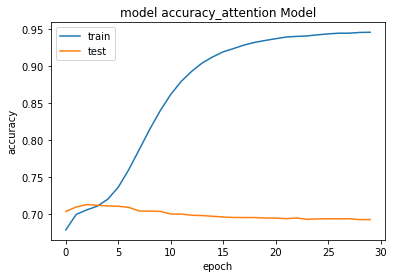

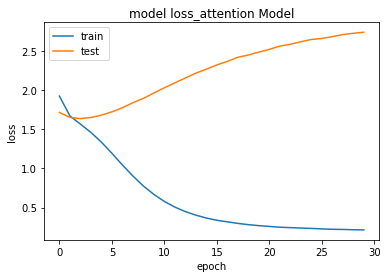

In [34]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy_attention Model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss_attention Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# 4. INFERENCE MODEL

In [35]:
model.save('chatbot.h5')
model.save_weights('chatbot_weights.h5')

# Attention Inference


In [36]:
enc_model = tf.keras.models.Model(enc_inp, [encoder_outputs, enc_states])


decoder_state_input_h = tf.keras.layers.Input(shape=( 400 * 2,))
decoder_state_input_c = tf.keras.layers.Input(shape=( 400 * 2,))

decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]


decoder_outputs, state_h, state_c = dec_lstm(dec_embed , initial_state=decoder_states_inputs)


decoder_states = [state_h, state_c]

#decoder_output = dec_dense(decoder_outputs)

dec_model = tf.keras.models.Model([dec_inp, decoder_states_inputs],
                                      [decoder_outputs] + decoder_states)


In [37]:

from keras.preprocessing.sequence import pad_sequences
print("##########################################")
print("#       start chatting ver. 1.0          #")
print("##########################################")


prepro1 = ""
while prepro1 != 'q':
    
    prepro1 = input("you : ")
    try:
        prepro1 = clean_text(prepro1)
        prepro = [prepro1]
        
        txt = []
        for x in prepro:
            lst = []
            for y in x.split():
                try:
                    lst.append(vocab[y])
                except:
                    lst.append(vocab['<OUT>'])
            txt.append(lst)
        txt = pad_sequences(txt, 20, padding='post')


        ###
        enc_op, stat = enc_model.predict( txt )

        empty_target_seq = np.zeros( ( 1 , 1) )
        empty_target_seq[0, 0] = vocab['<SOS>']
        stop_condition = False
        decoded_translation = ''


        while not stop_condition :

            dec_outputs , h , c = dec_model.predict([ empty_target_seq ] + stat )

            ###
            ###########################
            attn_op, attn_state = attn_layer([enc_op, dec_outputs])
            decoder_concat_input = Concatenate(axis=-1)([dec_outputs, attn_op])
            decoder_concat_input = dec_dense(decoder_concat_input)
            ###########################

            sampled_word_index = np.argmax( decoder_concat_input[0, -1, :] )

            sampled_word = inv_vocab[sampled_word_index] + ' '

            if sampled_word != '<EOS> ':
                decoded_translation += sampled_word           


            if sampled_word == '<EOS> ' or len(decoded_translation.split()) > 20:
                stop_condition = True

            empty_target_seq = np.zeros( ( 1 , 1 ) )  
            empty_target_seq[ 0 , 0 ] = sampled_word_index
            stat = [ h , c ] 

        print("chatbot attention : ", decoded_translation )
        print("==============================================")

    except:
        print("sorry didn't got you , please type again :( ")




##########################################
#       start chatting ver. 1.0          #
##########################################


you :  Hello


chatbot attention :  i have got to move what do you have <OUT> 


you :  sorry about that


chatbot attention :  i didnt know you had a sister 


you :  Yes, I do,


chatbot attention :  i got up 


you :  what's your name?


chatbot attention :  lisette 


you :  Nice meeting you.


chatbot attention :  you as well 


you :  Carry on. bye


chatbot attention :  but he will be real <OUT> 


you :  what?


chatbot attention :  i am sorry you are <OUT> 


you :  take care


chatbot attention :  hey do you want to have a drink i have lots 


you :  No. thanks.


chatbot attention :  my cars in the garage 


you :  good night


chatbot attention :  not particularly 


you :  bye


chatbot attention :  bye 


you :  q


chatbot attention :  i am looking 
